# Exploratory Data Analysis
In this analysis, there are a few questions that I would like to explore using the data. These are:
- How are the numerical data distributed and are they any obvious correlations?
- What genres are the most frequently made by anime studios?
- How do the genres an anime is labelled as affect the ratings of the anime?
- How many people rate an anime instead of only watching it? 
- For users that do rate animes, what are their mean and median ratings they give out?

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format

## Anime Dataset

In [2]:
# import anime dataset
anime_df = pd.read_csv("datasets/cleaned_anime.csv")
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.000,9.260,793665
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.000,9.250,114262
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.000,9.170,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.000,9.160,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.000,9.150,93351


In [3]:
# measures of central tendencies
anime_df[["episodes", "rating", "members"]].describe()

,episodes,rating,members
count,"3,578.000","3,671.000","3,787.000"
mean,35.916,6.902,"42,683.658"
std,80.640,0.864,"89,121.009"
min,2.000,2.670,12.000
25%,12.000,6.440,483.000
50%,24.000,6.940,"5,947.000"
75%,39.000,7.460,"44,246.000"
max,"1,818.000",9.600,"1,013,917.000"


In [4]:
# modes of each numerical category
mode = anime_df[["episodes", "rating", "members"]].mode()
mode.rename(index={0: "mode"})

,episodes,rating,members
mode,12.000,6.500,102


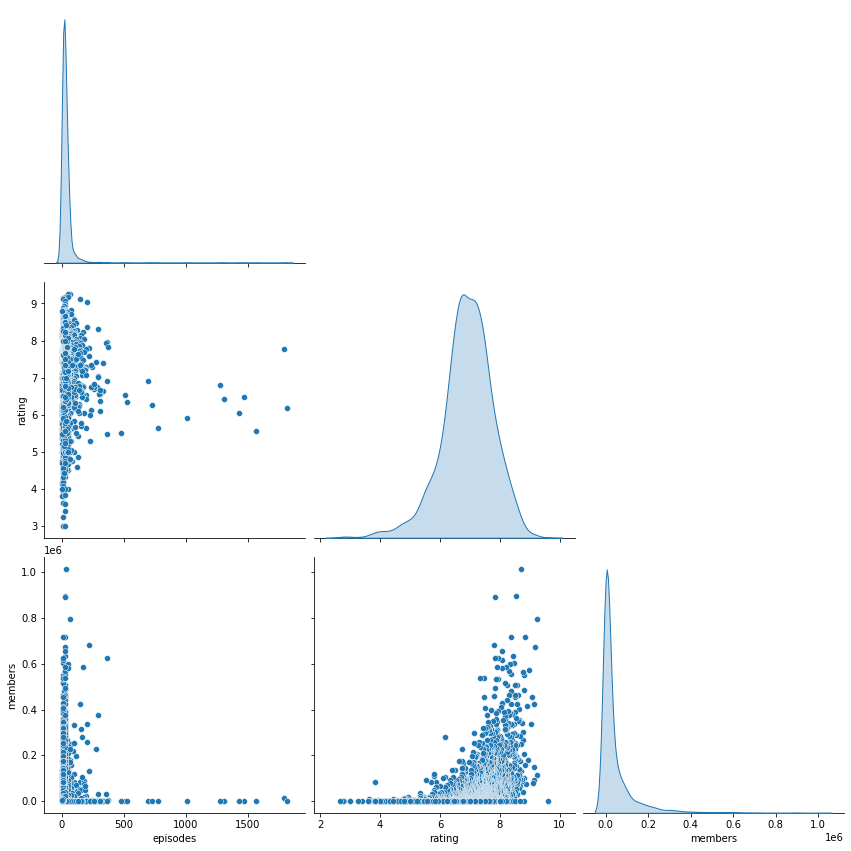

In [5]:
# pairplot
sns.pairplot(data = anime_df, vars=["episodes","rating", "members"], height=4, diag_kind= "kde", corner=True);

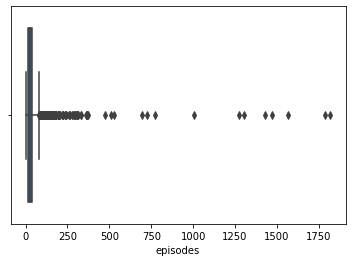

In [6]:
#boxplot of number of episodes
sns.boxplot(data=anime_df, x="episodes");

Looking at the histograms on the pair plot, we see that the distribution of ratings for shows seem to be **slightly left skewed** while the number of members seem to be **heavily right skewed**. These are also supported by the measures of central tendency. For the ratings, we see a **mode of 6**, a **median of 7**, and a **mean of 7**. Although numerically it seems reasonably symmetrically distributed, we say that visually it is quite obviously left skewed. This is most likely because the range of values is very small and so the distribution of the ratings data is not obvious when only using the mean, median, and mode. On the other hand the number of members has a **mode of 102**, **median of 5947**, and a **mean of 42684** justifying the assumption that it is heavily right skewed. The histogram for the number of episodes has extremely low frequencies of animes with high numbers of episodes however, looking at the boxplot and the numerical data, we see that the distribution is **left skewed** with a **mode of 12**, a **median of 24**, and a **mean of 36**.

All three distributions of the numerical data may suggest that some form of transformation may be required before building the recommendation system.

Regarding any correlations, it seems that there are no obvious correlations between the number of episodes and the amount of members, and also there seems to be no clear correlation between number of episodes and their average ratings. There does seem to a possible weak positive exponential relationship between the average rating a show gets compared to the number of members.  

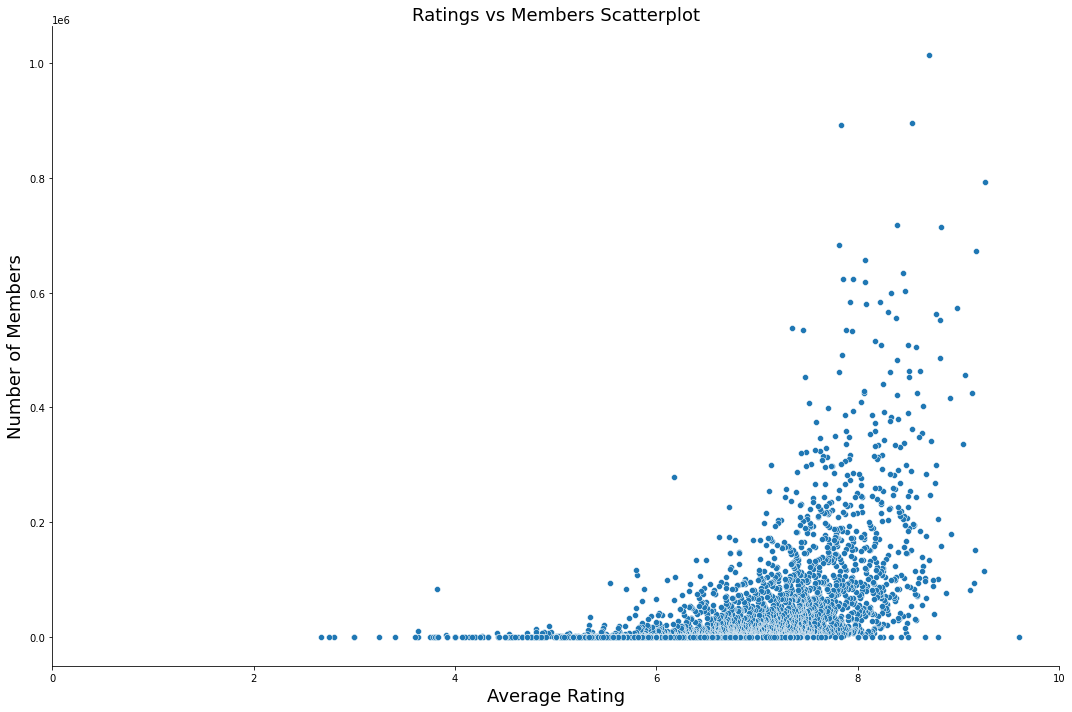

In [7]:
#plot ratings vs members
plt.figure(figsize=(15,10))
sns.scatterplot(data=anime_df, x="rating", y="members")
plt.title("Ratings vs Members Scatterplot", size=18)
plt.xlabel("Average Rating", size=18)
plt.xlim(0, 10)
plt.ylabel("Number of Members", size=18)
sns.despine()
plt.tight_layout()
plt.show()

In [8]:
# function to count the freq of animes for each genre
def count_genre_freq(df, column, delimiter=", "):
    from collections import Counter
    non_empty_rows = df[df[column].isnull() == False][column]
    row_counted = non_empty_rows.str.split(delimiter).apply(Counter)
    total_freq = dict(sum(row_counted, Counter()))
    freq_series = pd.Series(total_freq)
    output = freq_series.sort_values(ascending=False)
    return output

In [9]:
# Find total number of animes in the dataset that belong to a certain genre
animes_per_genre = count_genre_freq(anime_df, "genre")
animes_per_genre

Comedy           1870
Action           1098
Adventure         932
Sci-Fi            774
Fantasy           765
Shounen           712
Drama             697
Romance           652
School            567
Slice of Life     562
Kids              484
Supernatural      431
Mecha             379
Magic             353
Shoujo            283
Historical        275
Ecchi             245
Sports            240
Seinen            235
Mystery           222
Super Power       190
Harem             175
Military          133
Parody            126
Space             123
Music             123
Horror            113
Game              103
Martial Arts       95
Demons             89
Psychological      89
Samurai            51
Police             50
Vampire            46
Cars               36
Thriller           34
Josei              32
Shoujo Ai          31
Shounen Ai         24
Dementia            9
dtype: int64

In [10]:
# top 5 most frequent genres
animes_per_genre.head()

Comedy       1870
Action       1098
Adventure     932
Sci-Fi        774
Fantasy       765
dtype: int64

In [11]:
# 5 least frequent genres
animes_per_genre.tail()

Thriller      34
Josei         32
Shoujo Ai     31
Shounen Ai    24
Dementia       9
dtype: int64

It seems as though the 5 most frequent anime genres of the dataset are **Comedy, Action, Adventure, Sci-Fi, and Fantasy** while the genres with the lowest frequencies are **Thriller, Josei, Shoujo Ai, Shounen Ai, and Dementia**.

Let's visualise the numbers in a graph.

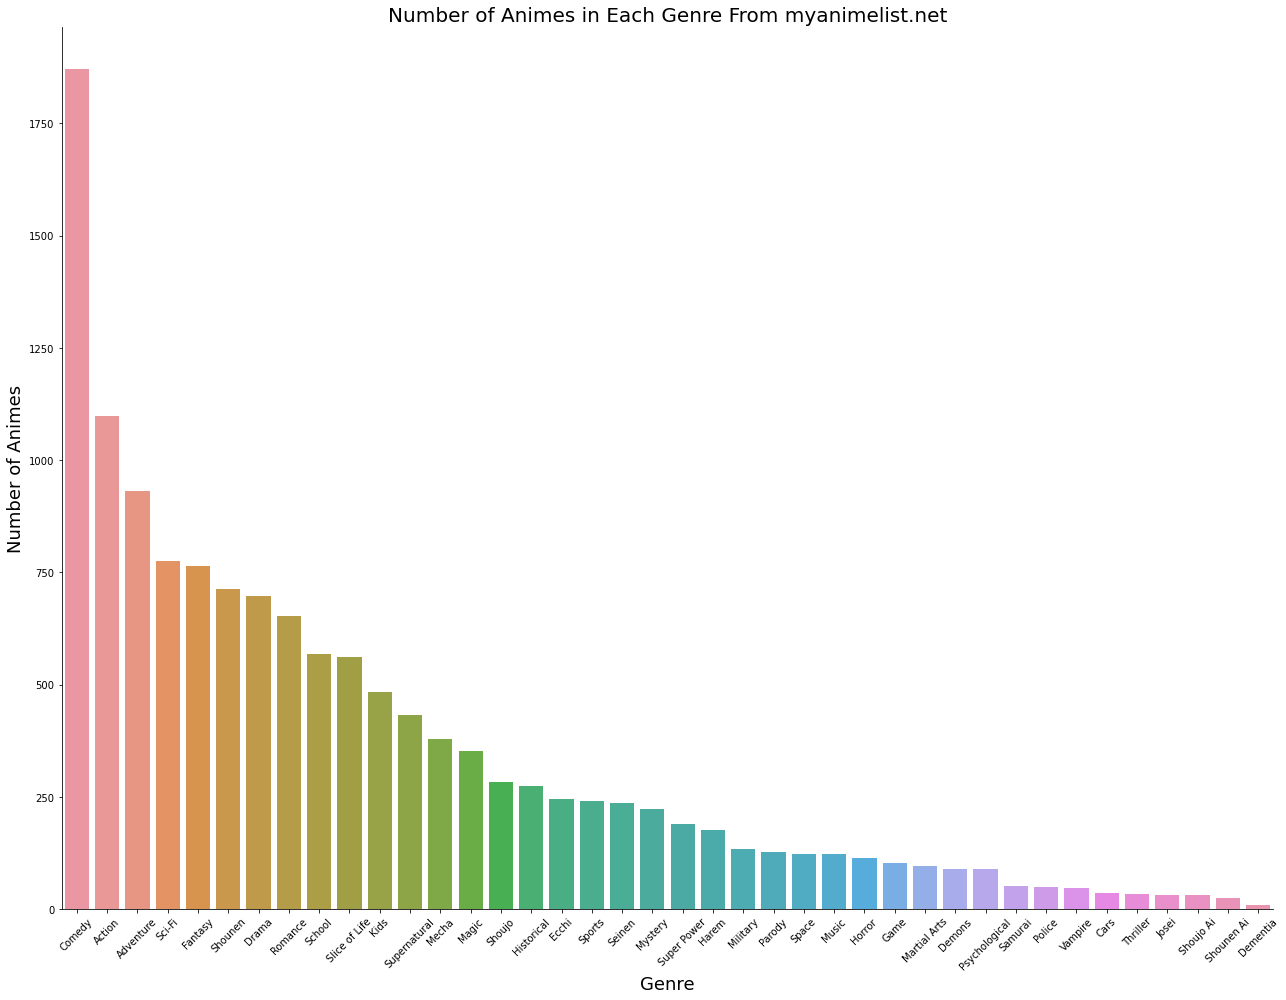

In [12]:
# plot the number of animes per genre
plt.figure(figsize=(18,14))
sns.barplot(x=animes_per_genre.index, y=animes_per_genre.values)
plt.xlabel("Genre", size=18)
plt.ylabel("Number of Animes", size=18)
plt.xticks(rotation=45)
plt.title("Number of Animes in Each Genre From myanimelist.net", size=20)
plt.tight_layout()
sns.despine();

Let's now compare the mean and median ratings for the top 5 most common genres versus the 5 least common genres. First I create a function that outputs the mean and median ratings for a given genre in addition to how many animes are labeled as said genre.

In [13]:
def find_mean_median_rating(df, string):
    # Create new dataframe that contains only the rows where the genre contains the given string and the ratings are not null
    output_df = df[df["genre"].str.contains(string, na=False) & ~np.isnan(df["rating"])]["rating"]
    return output_df.mean(), output_df.median(), output_df.count()


In [21]:
# Create a dictionary to save the information
mmc_dict = {}

After that it's time to input the genres and create a dataframe of the values.

In [22]:
top_5_genres = ["Comedy", "Action", "Adventure", "Sci-Fi", "Fantasy"]
for genre in top_5_genres:
    mean, median, count = find_mean_median_rating(anime_df, genre)
    dictionary[genre] = [round(mean, 3), round(median,3), count]

In [23]:
bottom_5_genres = ["Thriller", "Josei", "Shoujo Ai", "Shounen Ai", "Dementia"]
for genre in bottom_5_genres:
    mean, median, count = find_mean_median_rating(anime_df, genre)
    dictionary[genre] = [round(mean, 3), round(median,3), count]

In [16]:
# Convert into a dataframe
mmc_df = pd.DataFrame.from_dict(dictionary, orient="index", dtype="float", columns=["Mean", "Median", "Count"])

In [17]:
mmc_df

,Mean,Median,Count
Comedy,6.868,6.920,"1,828.000"
Action,7.107,7.130,"1,064.000"
Adventure,6.964,6.950,917.000
Sci-Fi,6.981,6.990,757.000
Fantasy,7.033,7.065,732.000
Thriller,7.886,8.025,34.000
Josei,7.610,7.600,30.000
Shoujo Ai,7.173,7.185,30.000
Shounen Ai,7.192,7.190,23.000
Dementia,7.207,7.210,7.000


I'm going to plot the information as it is hard to compare the values in the dataframe.

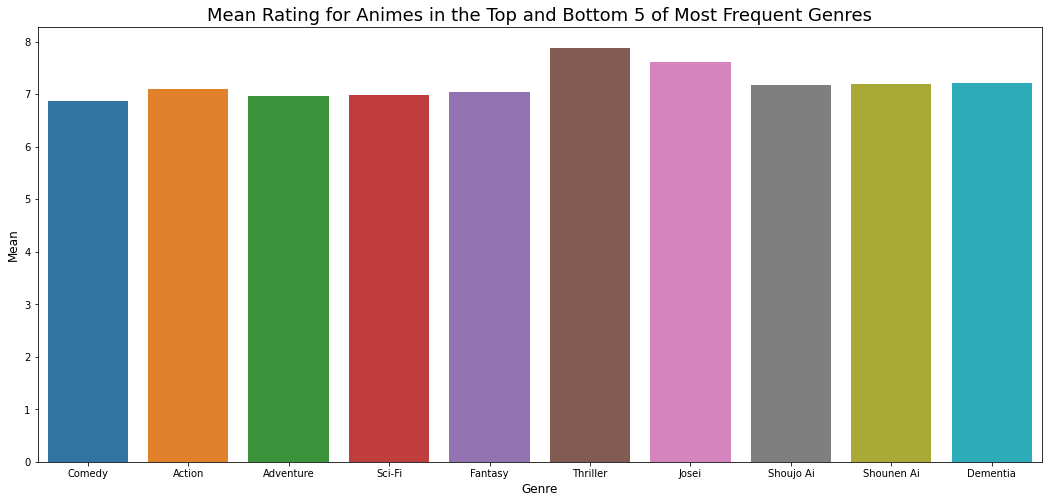

In [18]:
# Plot mean ratings
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Mean"])
plt.xlabel("Genre", size=12)
plt.ylabel("Mean", size=12)
plt.title("Mean Rating for Animes in the Top and Bottom 5 of Most Frequent Genres", size=18);

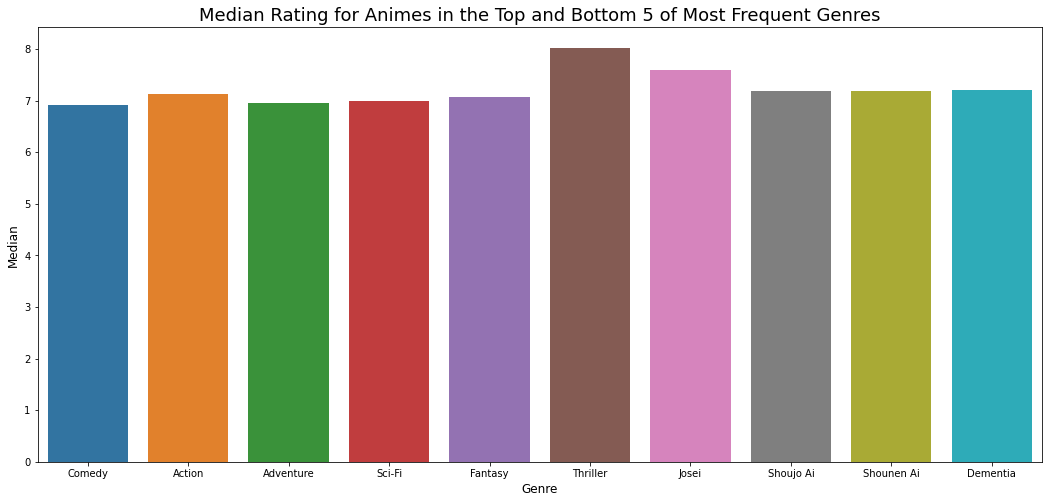

In [19]:
# Plot median ratings
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Median"])
plt.xlabel("Genre", size=12)
plt.ylabel("Median", size=12)
plt.title("Median Rating for Animes in the Top and Bottom 5 of Most Frequent Genres", size=18);

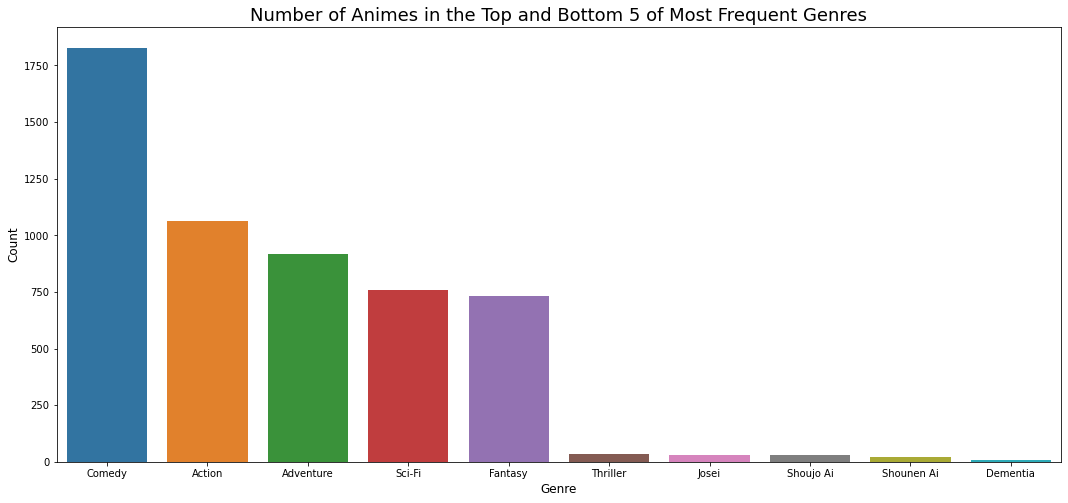

In [20]:
# Plot number of animes in the top
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Count"])
plt.xlabel("Genre", size=12)
plt.ylabel("Count", size=12)
plt.title("Number of Animes in the Top and Bottom 5 of Most Frequent Genres", size=18);

Looking at the bar graphs, it seems that all 10 of the genres have similar mean and median ratings of around 7 - 7.3 which is surprising as one may think the more popular anime genres who be rated higher. This may be due to the fact that Thriller, Josei, Shoujo Ai, Shounen Ai, and Dementia all have relatively tiny number of animes made and so the ratings may not reflect the true popularity of the genres.